# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [15]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.312206
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [16]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.901768 analytic: 0.901768, minus: 0.000000, relative error: 4.211765e-08
numerical: -1.033262 analytic: -1.033262, minus: 0.000000, relative error: 3.738551e-08
numerical: 1.882651 analytic: 1.882650, minus: 0.000000, relative error: 5.347712e-08
numerical: -0.681639 analytic: -0.681640, minus: 0.000000, relative error: 4.340731e-08
numerical: 0.579762 analytic: 0.579762, minus: 0.000000, relative error: 4.209873e-08
numerical: 0.922788 analytic: 0.922788, minus: 0.000000, relative error: 1.016426e-08
numerical: 1.325096 analytic: 1.325096, minus: 0.000000, relative error: 1.861986e-08
numerical: 0.000816 analytic: 0.000816, minus: 0.000000, relative error: 1.095855e-05
numerical: 3.366716 analytic: 3.366716, minus: 0.000000, relative error: 1.512310e-08
numerical: 0.615713 analytic: 0.615713, minus: 0.000000, relative error: 5.757343e-08
numerical: 0.205095 analytic: 0.205095, minus: 0.000000, relative error: 6.387088e-09
numerical: -0.950101 analytic: -0.950101, minus: 0

In [20]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.312206e+00 computed in 0.104899s
vectorized loss: 2.312206e+00 computed in 0.003279s
Loss difference: 0.000000
Gradient difference: 0.000000


lr: 0.01 reg: 10.0
iteration 0 / 1500: loss 5.791753
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss inf
iteration 700 / 1500: loss inf
iteration 800 / 1500: loss inf
iteration 900 / 1500: loss inf
iteration 1000 / 1500: loss inf
iteration 1100 / 1500: loss inf
iteration 1200 / 1500: loss inf
iteration 1300 / 1500: loss inf
iteration 1400 / 1500: loss inf
tr_acc: 0.199653061224 val_acc: 0.205


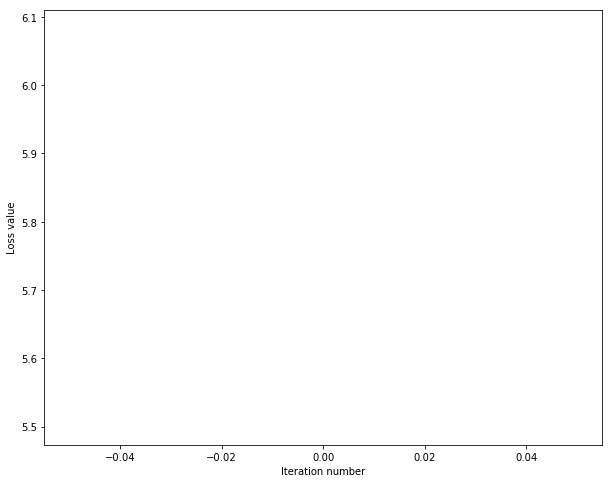

lr: 0.01 reg: 50000.0
iteration 0 / 1500: loss 779.422011
iteration 100 / 1500: loss inf


cs231n/classifiers/softmax.py:79: RuntimeWarning: overflow encountered in subtract
  scores -= np.reshape(np.max(scores, axis=1), (-1, 1)) # for numeric stability
cs231n/classifiers/softmax.py:79: RuntimeWarning: invalid value encountered in subtract
  scores -= np.reshape(np.max(scores, axis=1), (-1, 1)) # for numeric stability


iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
tr_acc: 0.100265306122 val_acc: 0.087


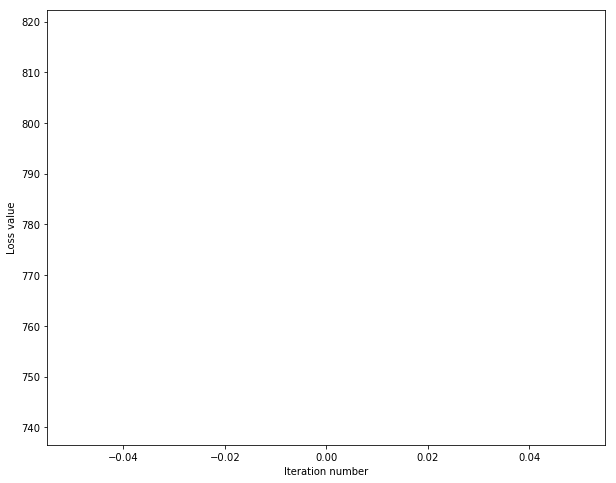

lr: 0.01 reg: 100000.0
iteration 0 / 1500: loss 1535.741737
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
tr_acc: 0.100265306122 val_acc: 0.087


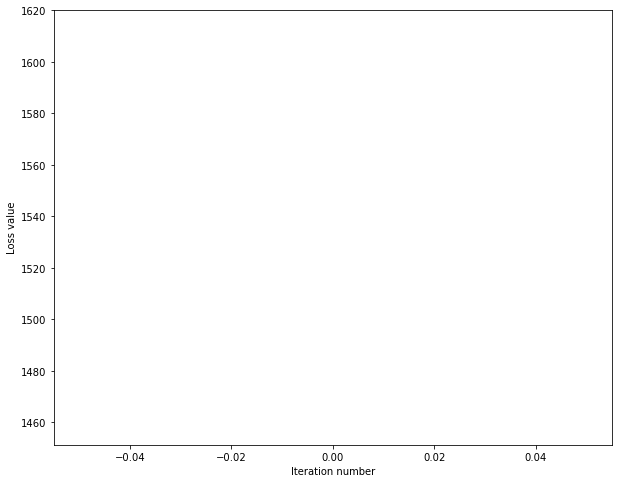

lr: 0.01 reg: 10000000.0
iteration 0 / 1500: loss 151685.887345
iteration 100 / 1500: loss nan
iteration 200 / 1500: loss nan
iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
tr_acc: 0.100265306122 val_acc: 0.087


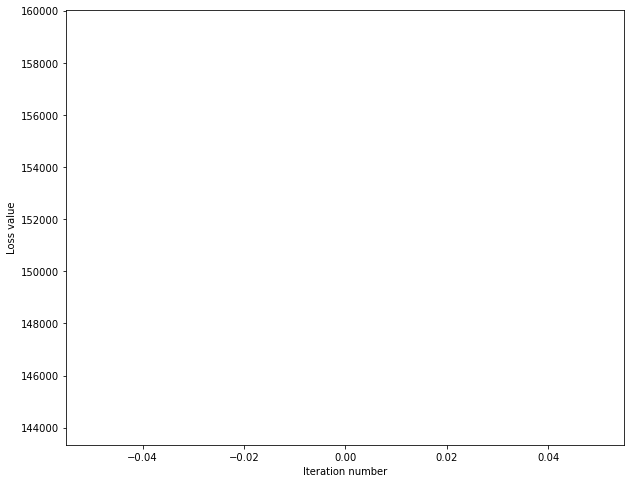

lr: 1e-07 reg: 10.0
iteration 0 / 1500: loss 6.895679
iteration 100 / 1500: loss 4.171097
iteration 200 / 1500: loss 3.943118
iteration 300 / 1500: loss 3.634916
iteration 400 / 1500: loss 3.253693
iteration 500 / 1500: loss 3.347202
iteration 600 / 1500: loss 3.252439
iteration 700 / 1500: loss 2.983900
iteration 800 / 1500: loss 3.015946
iteration 900 / 1500: loss 2.929428
iteration 1000 / 1500: loss 2.938926
iteration 1100 / 1500: loss 2.949416
iteration 1200 / 1500: loss 2.889580
iteration 1300 / 1500: loss 2.545999
iteration 1400 / 1500: loss 2.910029
tr_acc: 0.254571428571 val_acc: 0.261


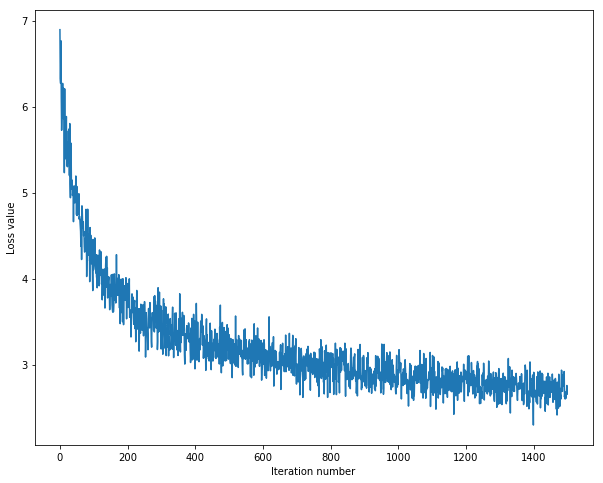

lr: 1e-07 reg: 50000.0
iteration 0 / 1500: loss 776.908769
iteration 100 / 1500: loss 285.435528
iteration 200 / 1500: loss 105.758759
iteration 300 / 1500: loss 40.034380
iteration 400 / 1500: loss 15.953554
iteration 500 / 1500: loss 7.178992
iteration 600 / 1500: loss 3.967454
iteration 700 / 1500: loss 2.707063
iteration 800 / 1500: loss 2.340769
iteration 900 / 1500: loss 2.159341
iteration 1000 / 1500: loss 2.087857
iteration 1100 / 1500: loss 2.093454
iteration 1200 / 1500: loss 2.122499
iteration 1300 / 1500: loss 2.125040
iteration 1400 / 1500: loss 2.053398
tr_acc: 0.331836734694 val_acc: 0.352


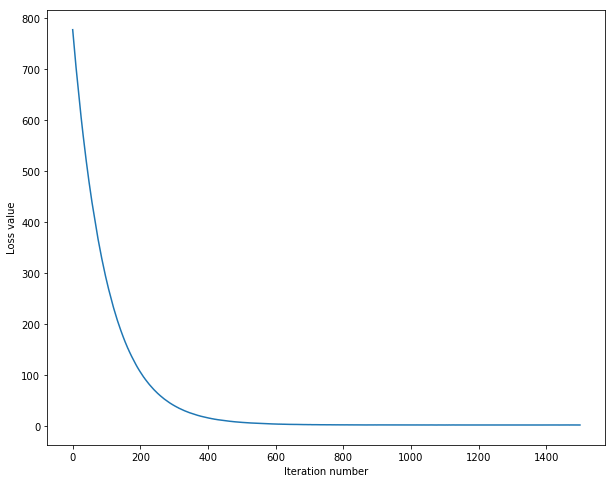

lr: 1e-07 reg: 100000.0
iteration 0 / 1500: loss 1556.209003
iteration 100 / 1500: loss 209.633844
iteration 200 / 1500: loss 29.825705
iteration 300 / 1500: loss 5.862769
iteration 400 / 1500: loss 2.638535
iteration 500 / 1500: loss 2.203294
iteration 600 / 1500: loss 2.139027
iteration 700 / 1500: loss 2.149196
iteration 800 / 1500: loss 2.153246
iteration 900 / 1500: loss 2.070653
iteration 1000 / 1500: loss 2.097055
iteration 1100 / 1500: loss 2.147071
iteration 1200 / 1500: loss 2.109154
iteration 1300 / 1500: loss 2.127435
iteration 1400 / 1500: loss 2.147786
tr_acc: 0.317244897959 val_acc: 0.329


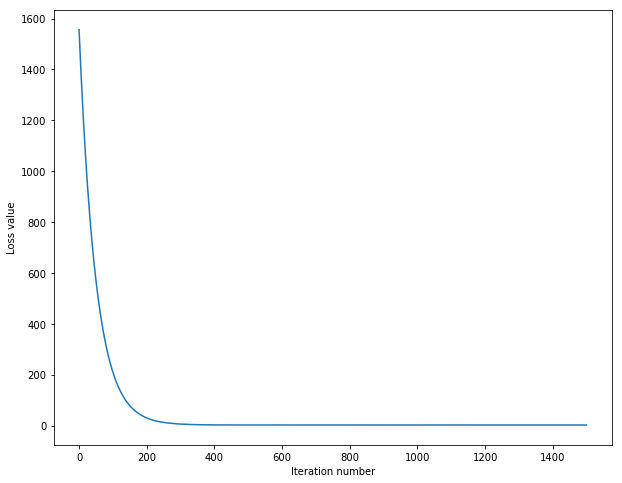

lr: 1e-07 reg: 10000000.0
iteration 0 / 1500: loss 154097.692801
iteration 100 / 1500: loss 2.302735
iteration 200 / 1500: loss 2.299451
iteration 300 / 1500: loss 2.298735
iteration 400 / 1500: loss 2.300945
iteration 500 / 1500: loss 2.300780
iteration 600 / 1500: loss 2.302278
iteration 700 / 1500: loss 2.300214
iteration 800 / 1500: loss 2.302728
iteration 900 / 1500: loss 2.301181
iteration 1000 / 1500: loss 2.299253
iteration 1100 / 1500: loss 2.303101
iteration 1200 / 1500: loss 2.299993
iteration 1300 / 1500: loss 2.300241
iteration 1400 / 1500: loss 2.301586
tr_acc: 0.22412244898 val_acc: 0.234


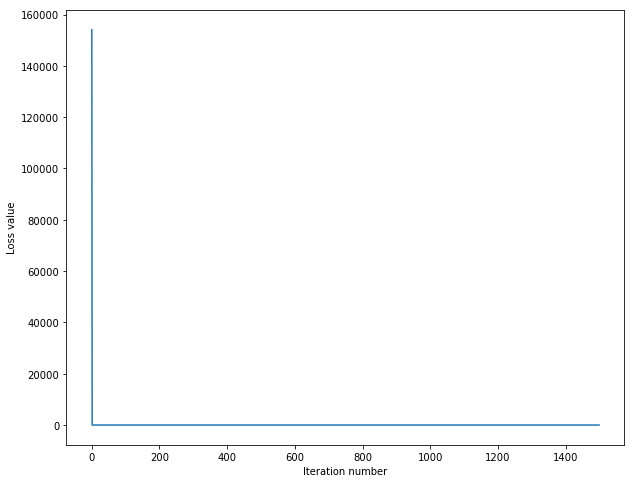

lr: 5e-07 reg: 10.0
iteration 0 / 1500: loss 5.687047
iteration 100 / 1500: loss 3.086525
iteration 200 / 1500: loss 2.777820
iteration 300 / 1500: loss 2.473207
iteration 400 / 1500: loss 3.034449
iteration 500 / 1500: loss 2.441801
iteration 600 / 1500: loss 2.644871
iteration 700 / 1500: loss 2.420668
iteration 800 / 1500: loss 2.677843
iteration 900 / 1500: loss 2.319332
iteration 1000 / 1500: loss 2.230576
iteration 1100 / 1500: loss 2.292574
iteration 1200 / 1500: loss 2.338200
iteration 1300 / 1500: loss 2.243953
iteration 1400 / 1500: loss 2.407675
tr_acc: 0.318653061224 val_acc: 0.312


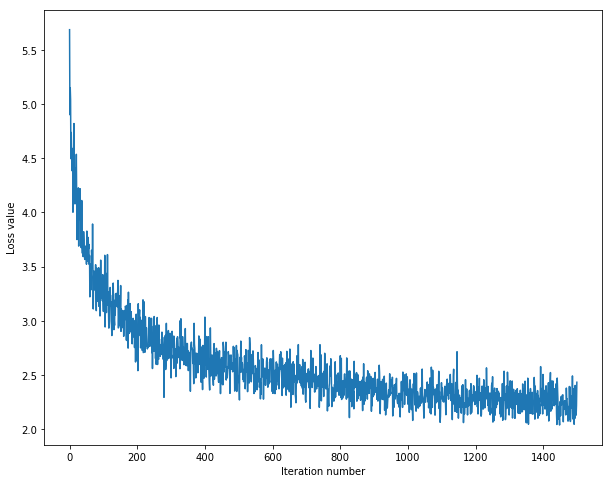

lr: 5e-07 reg: 50000.0
iteration 0 / 1500: loss 772.356145
iteration 100 / 1500: loss 6.900413
iteration 200 / 1500: loss 2.136504
iteration 300 / 1500: loss 2.109423
iteration 400 / 1500: loss 2.058036
iteration 500 / 1500: loss 2.011776
iteration 600 / 1500: loss 2.134744
iteration 700 / 1500: loss 2.100732
iteration 800 / 1500: loss 2.080072
iteration 900 / 1500: loss 2.073378
iteration 1000 / 1500: loss 2.049040
iteration 1100 / 1500: loss 2.085898
iteration 1200 / 1500: loss 2.164516
iteration 1300 / 1500: loss 2.088773
iteration 1400 / 1500: loss 2.084309
tr_acc: 0.318408163265 val_acc: 0.33


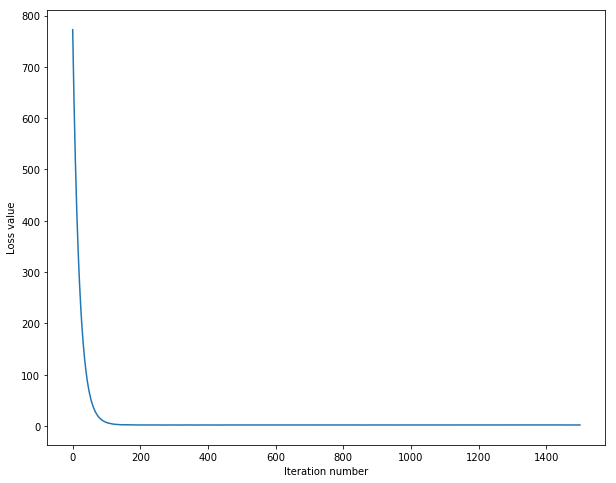

lr: 5e-07 reg: 100000.0
iteration 0 / 1500: loss 1521.227911
iteration 100 / 1500: loss 2.143655
iteration 200 / 1500: loss 2.159399
iteration 300 / 1500: loss 2.154052
iteration 400 / 1500: loss 2.096209
iteration 500 / 1500: loss 2.192666
iteration 600 / 1500: loss 2.120279
iteration 700 / 1500: loss 2.098024
iteration 800 / 1500: loss 2.169800
iteration 900 / 1500: loss 2.150648
iteration 1000 / 1500: loss 2.119780
iteration 1100 / 1500: loss 2.125500
iteration 1200 / 1500: loss 2.165607
iteration 1300 / 1500: loss 2.123171
iteration 1400 / 1500: loss 2.211320
tr_acc: 0.309897959184 val_acc: 0.325


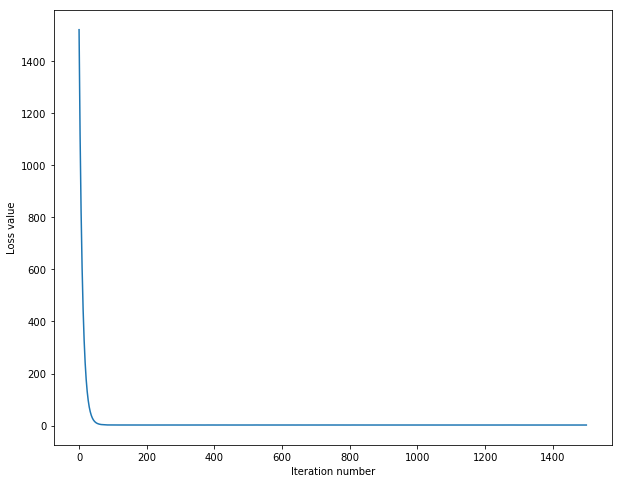

lr: 5e-07 reg: 10000000.0
iteration 0 / 1500: loss 154723.908408
iteration 100 / 1500: loss inf
iteration 200 / 1500: loss inf
iteration 300 / 1500: loss inf
iteration 400 / 1500: loss inf
iteration 500 / 1500: loss inf
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
tr_acc: 0.100265306122 val_acc: 0.087


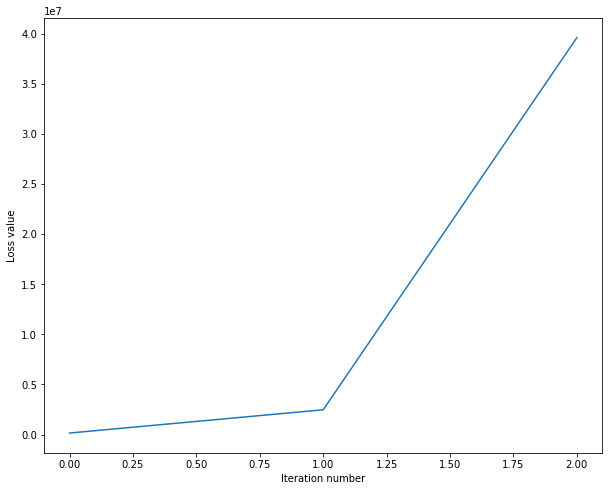

lr: 1e-10 reg: 10.0
iteration 0 / 1500: loss 6.521596
iteration 100 / 1500: loss 6.137653
iteration 200 / 1500: loss 6.663159
iteration 300 / 1500: loss 6.728993
iteration 400 / 1500: loss 6.343762
iteration 500 / 1500: loss 6.715973
iteration 600 / 1500: loss 5.511821
iteration 700 / 1500: loss 6.530057
iteration 800 / 1500: loss 6.213818
iteration 900 / 1500: loss 6.016974
iteration 1000 / 1500: loss 6.004757
iteration 1100 / 1500: loss 6.282585
iteration 1200 / 1500: loss 6.090982
iteration 1300 / 1500: loss 6.664948
iteration 1400 / 1500: loss 6.297111
tr_acc: 0.100918367347 val_acc: 0.108


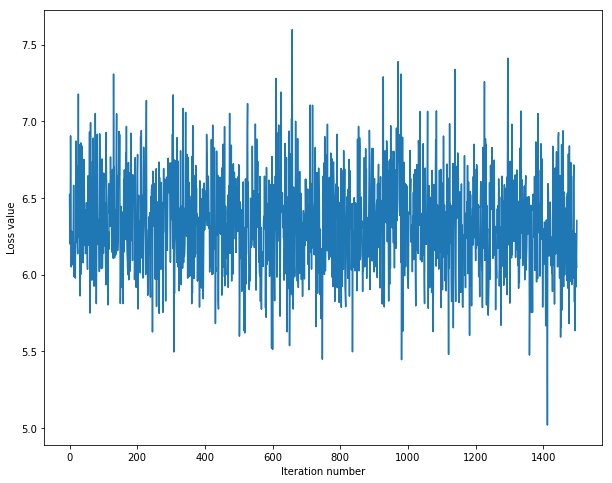

lr: 1e-10 reg: 50000.0
iteration 0 / 1500: loss 774.678152
iteration 100 / 1500: loss 773.468183
iteration 200 / 1500: loss 772.679630
iteration 300 / 1500: loss 771.751982
iteration 400 / 1500: loss 771.293093
iteration 500 / 1500: loss 770.077076
iteration 600 / 1500: loss 769.546979
iteration 700 / 1500: loss 768.529921
iteration 800 / 1500: loss 768.555873
iteration 900 / 1500: loss 767.206654
iteration 1000 / 1500: loss 765.906930
iteration 1100 / 1500: loss 765.502484
iteration 1200 / 1500: loss 765.064198
iteration 1300 / 1500: loss 764.165718
iteration 1400 / 1500: loss 763.286040
tr_acc: 0.099306122449 val_acc: 0.105


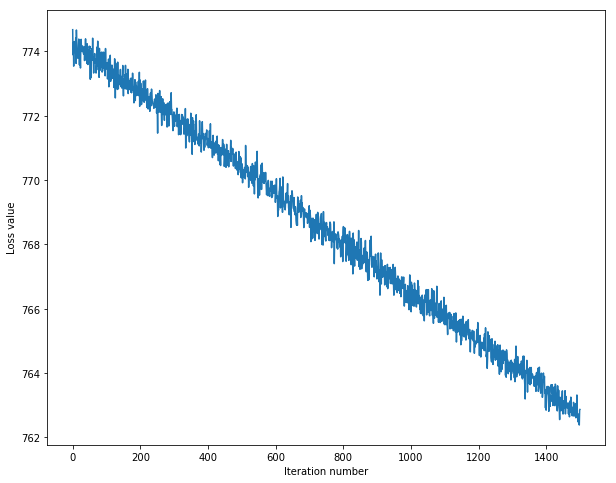

lr: 1e-10 reg: 100000.0
iteration 0 / 1500: loss 1529.107557
iteration 100 / 1500: loss 1525.934154
iteration 200 / 1500: loss 1522.792572
iteration 300 / 1500: loss 1519.961952
iteration 400 / 1500: loss 1517.195554
iteration 500 / 1500: loss 1513.597087
iteration 600 / 1500: loss 1511.032702
iteration 700 / 1500: loss 1508.110261
iteration 800 / 1500: loss 1505.040669
iteration 900 / 1500: loss 1502.587160
iteration 1000 / 1500: loss 1499.094145
iteration 1100 / 1500: loss 1495.984399
iteration 1200 / 1500: loss 1493.011470
iteration 1300 / 1500: loss 1489.872641
iteration 1400 / 1500: loss 1486.754214
tr_acc: 0.0978979591837 val_acc: 0.091


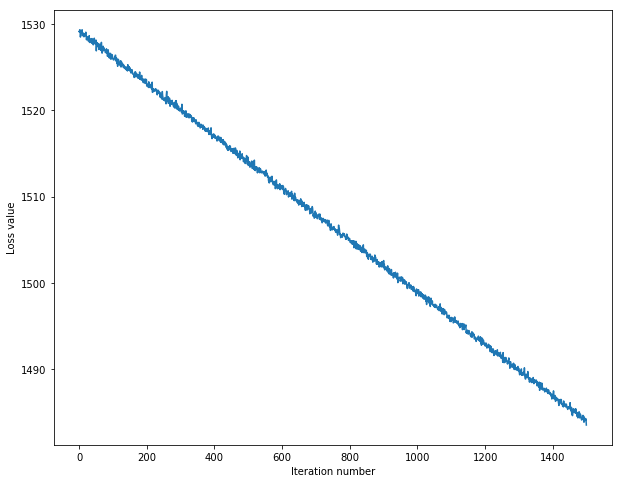

lr: 1e-10 reg: 10000000.0
iteration 0 / 1500: loss 154110.801972
iteration 100 / 1500: loss 126162.940208
iteration 200 / 1500: loss 103283.173340
iteration 300 / 1500: loss 84552.793226
iteration 400 / 1500: loss 69219.266460
iteration 500 / 1500: loss 56666.512449
iteration 600 / 1500: loss 46390.027825
iteration 700 / 1500: loss 37977.457847
iteration 800 / 1500: loss 31090.694140
iteration 900 / 1500: loss 25452.611133
iteration 1000 / 1500: loss 20837.036229
iteration 1100 / 1500: loss 17058.624215
iteration 1200 / 1500: loss 13965.413000
iteration 1300 / 1500: loss 11433.165752
iteration 1400 / 1500: loss 9360.073592
tr_acc: 0.113387755102 val_acc: 0.102


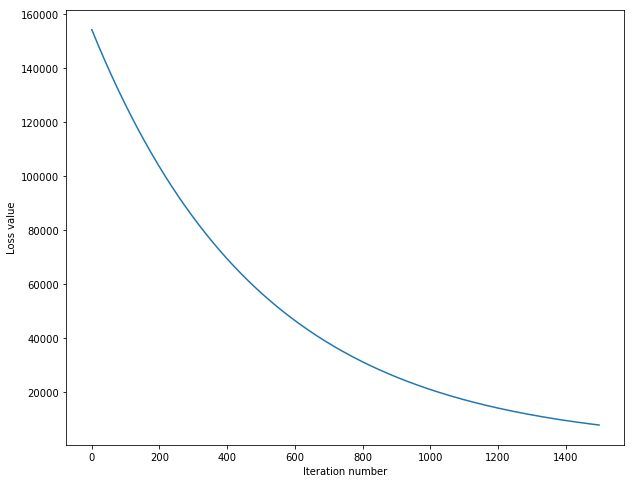

lr 1.000000e-10 reg 1.000000e+01 train accuracy: 0.100918 val accuracy: 0.108000
lr 1.000000e-10 reg 5.000000e+04 train accuracy: 0.099306 val accuracy: 0.105000
lr 1.000000e-10 reg 1.000000e+05 train accuracy: 0.097898 val accuracy: 0.091000
lr 1.000000e-10 reg 1.000000e+07 train accuracy: 0.113388 val accuracy: 0.102000
lr 1.000000e-07 reg 1.000000e+01 train accuracy: 0.254571 val accuracy: 0.261000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.331837 val accuracy: 0.352000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.317245 val accuracy: 0.329000
lr 1.000000e-07 reg 1.000000e+07 train accuracy: 0.224122 val accuracy: 0.234000
lr 5.000000e-07 reg 1.000000e+01 train accuracy: 0.318653 val accuracy: 0.312000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.318408 val accuracy: 0.330000
lr 5.000000e-07 reg 1.000000e+05 train accuracy: 0.309898 val accuracy: 0.325000
lr 5.000000e-07 reg 1.000000e+07 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-02 reg 1.000000

In [24]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-2, 1e-7, 5e-7, 1e-10]
regularization_strengths = [1e1, 5e4, 1e5, 1e7]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
from cs231n.classifiers import Softmax
for lr in learning_rates:
    for reg in regularization_strengths:
        print "lr:", lr, "reg:", reg
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, lr, reg, num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_acc = np.mean(y_train_pred == y_train)
        y_val_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val_pred == y_val)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = softmax
        print 'tr_acc:', train_acc, 'val_acc:', val_acc
        plt.plot(loss_hist)
        plt.xlabel('Iteration number')
        plt.ylabel('Loss value')
        plt.show()
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

In [25]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.334000


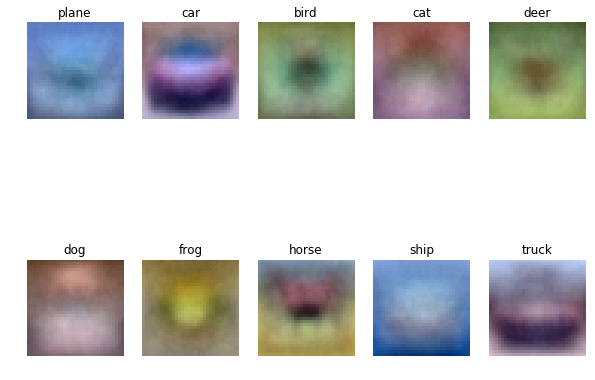

In [26]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])